# Problem 4 - Siamese Network for Face Recognition

## 4.1

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [92]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [93]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [94]:
# Download the dataset from github referenced in the assignment question
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2023-11-07 02:20:38--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2023-11-07 02:20:38--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip.2’

at&t.zip.2          100%[===================>]   3.62M  --.-KB/s    in 0.03s   

2023-11-07 02:20:38 (119 MB/s) - ‘at&t.zip.2’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating

In [95]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

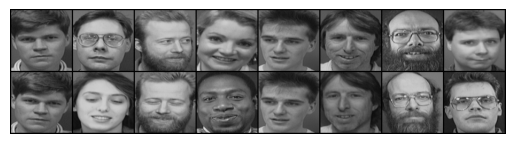

[0. 1. 0. 1. 0. 0. 0. 1.]


In [96]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=2, batch_size=8)
example_batch = next(iter(vis_dataloader))
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [97]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [98]:
# Define the Contrastive Loss Function (evaluating the Siamese network)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [99]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.0601649284362793

Epoch number 1
 Current loss 1.3109350204467773

Epoch number 2
 Current loss 0.7566714286804199

Epoch number 3
 Current loss 0.717065691947937

Epoch number 4
 Current loss 0.7187901139259338

Epoch number 5
 Current loss 0.6569358110427856

Epoch number 6
 Current loss 0.7324296236038208

Epoch number 7
 Current loss 0.7066943049430847

Epoch number 8
 Current loss 0.818925678730011

Epoch number 9
 Current loss 0.6219470500946045

Epoch number 10
 Current loss 0.34374314546585083

Epoch number 11
 Current loss 0.6158838272094727

Epoch number 12
 Current loss 0.8067957162857056

Epoch number 13
 Current loss 0.58669513463974

Epoch number 14
 Current loss 0.5142518877983093

Epoch number 15
 Current loss 0.4888914227485657

Epoch number 16
 Current loss 0.5328186750411987

Epoch number 17
 Current loss 0.39423611760139465

Epoch number 18
 Current loss 0.2843806743621826

Epoch number 19
 Current loss 0.21047642827033997

Epoch numbe

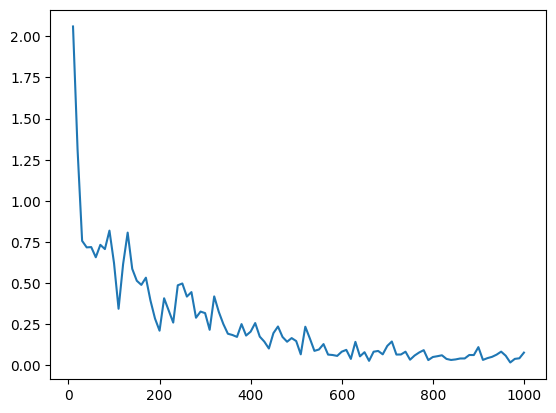

In [100]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

- Initially, the loss is high because the model has random weights and thus makes a lot of errors. This is due to the fact that the model has not learned the distinct feature between similiar and dissimiliar images.
- As the epochs progress, the loss decrease rate slows down, and the model starts to converge, indicating that the network is approaching its optimal state for the given training data.

The loss decreasing and eventually plateauing indicates successful learning, suggesting that the Siamese network is effectively distinguishing between similar and dissimilar image pairs as training progresses.

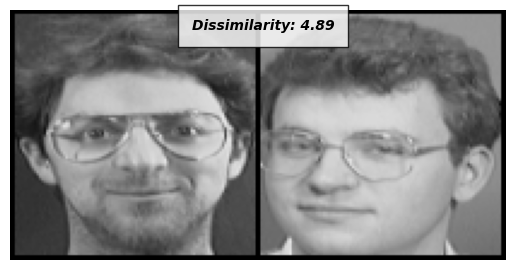

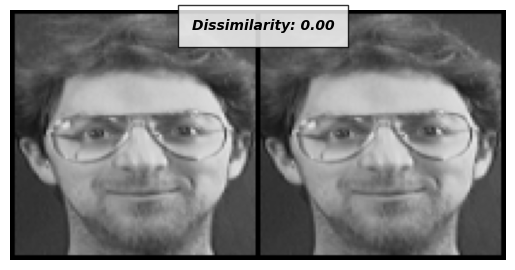

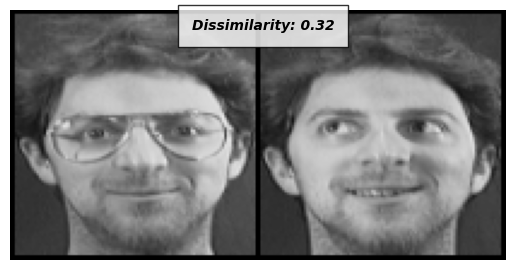

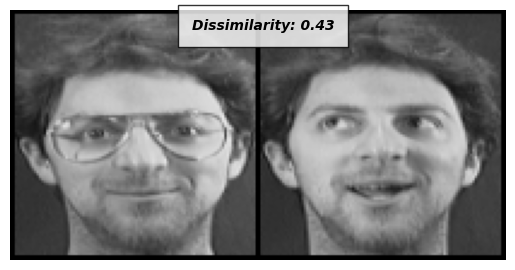

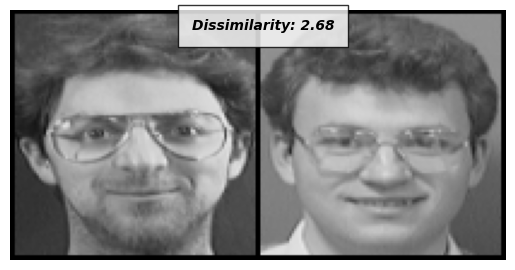

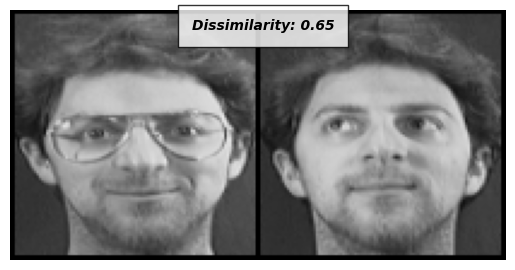

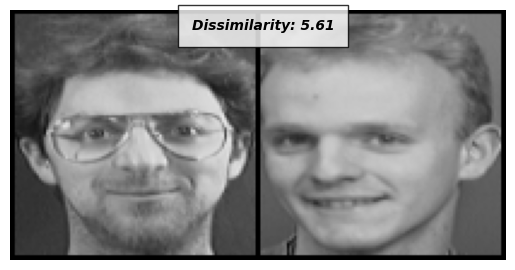

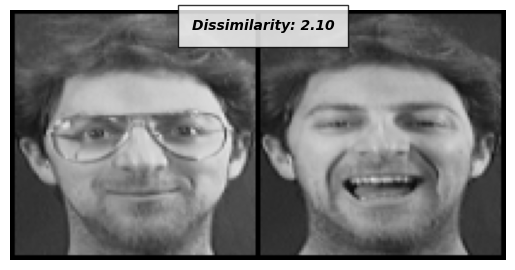

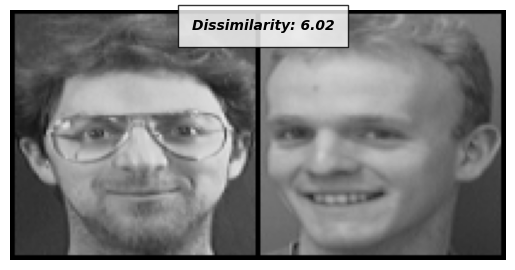

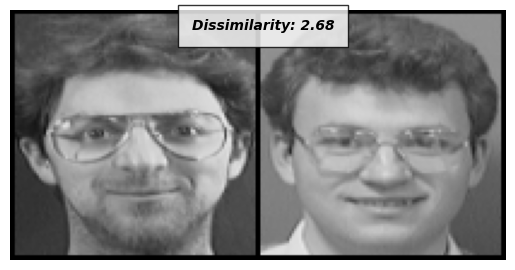

In [101]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    i, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## 4.2

- A range of potential thresholds is defined from `0` to the maximum computed distance.
- For each threshold within the range, it computes the predictions where: if the distance is greater than the threshold, the images are predicted as `1`, else they are predicted as `0`.
- The F1 score is the harmonic mean of precision and recall, making it a suitable metric when class distributions are imbalanced. A higher F1 score indicates better precision and recall.
- The threshold that results in the highest F1 score is selected as the optimal threshold. A higher F1 score indicates better precision and recall.
- In imbalanced datasets or when both false positives and false negatives have significant implications, selecting the threshold that maximizes the F1 score helps us in finding a balance between the precision and recall.

In [104]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch

def determine_threshold(net, dataloader):
    net.eval()

    distances = []
    labels = []

    with torch.no_grad():
        for i, (img0, img1, label) in enumerate(dataloader):
            output1, output2 = net(img0.cuda(), img1.cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(label.cpu().numpy())

    distances = np.array(distances).flatten()
    labels = np.array(labels).flatten()

    thresholds = np.linspace(0, distances.max(), 1000)

    best_threshold = 0
    best_f1 = 0
    best_accuracy = 0
    for thresh in thresholds:
        predictions = (distances > thresh).astype(int)
        current_f1 = f1_score(labels, predictions)
        current_accuracy = accuracy_score(labels, predictions)
        if current_f1 >= best_f1:
            best_f1 = current_f1
            best_accuracy = current_accuracy
            best_threshold = thresh

    return best_threshold, best_accuracy

threshold, accuracy = determine_threshold(net, train_dataloader)
print(f"Optimal threshold: {threshold:.2f}")
print(f"Highest accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Optimal threshold: 0.90
Highest accuracy: 1.00


* When using Euclidean distance to compare feature vectors, a perfect accuracy of 100% was achieved with a threshold of 0.90.
* This means that every pair of images was correctly classified, with all same-person pairs having a Euclidean distance less than 0.90 and all different-person pairs having a greater distance.

## 4.3

In [105]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define a function to read image IDs from files
def read_image_ids(file_path):
    with open(file_path, 'r') as file:
        return file.read().splitlines()

# Function to pair image IDs with and without glasses
def pair_image_ids(ids_glasses, ids_no_glasses):
    paired = []
    count = 0
    for id_glass in ids_glasses:
        base_id = id_glass.split('@')[0]
        if base_id in ids_no_glasses:
            paired.append((id_glass, ids_no_glasses[base_id]))
            count += 1
    return paired, count

# Read image IDs from files
ids_with_glasses = read_image_ids('/content/black_glass.txt')
ids_without_glasses = {id.split('@')[0]: id for id in read_image_ids('/content/no_glass.txt')}

# Create a dictionary of paired IDs
pairs, num = pair_image_ids(ids_with_glasses, ids_without_glasses)

# MeGlass dataset directory
dataset_folder = "MeGlass_120x120"

# Custom dataset for the MeGlass dataset
class MeGlassDataset(Dataset):
    def __init__(self, directory, image_pairs, transform=None):
        self.directory = directory
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        with_id, without_id = self.image_pairs[idx]
        path_with = os.path.join(self.directory, with_id)
        path_without = os.path.join(self.directory, without_id)
        image_with = Image.open(path_with).convert('L')
        image_without = Image.open(path_without).convert('L')

        if self.transform:
            image_with = self.transform(image_with)
            image_without = self.transform(image_without)

        return image_with, image_without

# Transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

# Initialize the dataset and dataloader
meglass_dataset = MeGlassDataset(dataset_folder, pairs, transform_pipeline)
meglass_dataloader = DataLoader(meglass_dataset, batch_size=1, shuffle=False)

# Network evaluation loop
net.eval()
match_counter = 0
for with_img, without_img in meglass_dataloader:
    with_img, without_img = with_img.cuda(), without_img.cuda()
    with_output, without_output = net(with_img, without_img)
    distance = F.pairwise_distance(with_output, without_output)

    # Count matches based on the distance
    if distance.item() < threshold:
        match_counter += 1

# Compute and print the match ratio
match_ratio = match_counter / num
print("Match Ratio:", match_ratio)


Match Ratio: 0.02982456140350877


**Answer:**

* The match ratio (approximately 0.0298 or about 2.98%) indicates the performance of the face recognition system on the MeGlass dataset Specifically, this match ratio refers to the proportion of image pairs (each pair consisting of two images of the same person, one with glasses and one without glasses) that the system correctly identified as the same individual.
* In this specific case, a match ratio of 2.98% is actuallyquite low. This implies that out of all the pairs tested, the system only correctly matched roughly 2.98 out of every 100 pairs. 
* Such a result suggests that the system is not performing well on the task of recognizing that two images represent the same person when that person is wearing glasses in one image and not in the other.

## 4.4

In [106]:
class MiningContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MiningContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the cosine similarity
        cos_sim = F.cosine_similarity(output1, output2)

        # Calculate losses for positive and negative pairs
        positive_loss = label * (1 - cos_sim)
        negative_loss = (1 - label) * F.relu(cos_sim - self.margin)

        # Combine losses
        loss = positive_loss + negative_loss
        return loss.mean()

In [107]:
net = SiameseNetwork().cuda()
criterion = MiningContrastiveLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
epochs = 100
for epoch in range(epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, Loss: 2.0809820853173733e-05
Epoch: 2, Loss: 1.2103264452889562e-06
Epoch: 3, Loss: 2.167362254112959e-07
Epoch: 4, Loss: 1.9565050024539232e-07
Epoch: 5, Loss: 2.8463546186685562e-08
Epoch: 6, Loss: 1.4668330550193787e-08
Epoch: 7, Loss: 2.5029294192790985e-08
Epoch: 8, Loss: 1.4260876923799515e-08
Epoch: 9, Loss: 1.257285475730896e-08
Epoch: 10, Loss: 1.6239937394857407e-08
Epoch: 11, Loss: 1.201988197863102e-08
Epoch: 12, Loss: 9.080395102500916e-09
Epoch: 13, Loss: 9.720679372549057e-09
Epoch: 14, Loss: 9.66247171163559e-09
Epoch: 15, Loss: 4.918547347187996e-09
Epoch: 16, Loss: 8.527422323822975e-09
Epoch: 17, Loss: 1.3416865840554237e-08
Epoch: 18, Loss: 1.072476152330637e-08
Epoch: 19, Loss: 1.3154931366443634e-08
Epoch: 20, Loss: 9.15315467864275e-09
Epoch: 21, Loss: 7.334165275096893e-09
Epoch: 22, Loss: 9.793438948690891e-09
Epoch: 23, Loss: 6.984919309616089e-09
Epoch: 24, Loss: 1.5032128430902958e-08
Epoch: 25, Loss: 1.3969838619232178e-08
Epoch: 26, Loss: 1.42463

In [108]:
def determine_threshold(net, loader):
    net.eval()
    cosine_similarities = []
    labels = []
    with torch.no_grad():
        for img0, img1, label in loader:
            img0, img1 = img0.cuda(), img1.cuda()
            output1, output2 = net(img0, img1)
            cos = F.cosine_similarity(output1, output2)
            cosine_similarities.extend(cos.cpu().numpy())
            labels.extend(label.cpu().numpy())

    labels = np.array(labels)
    cosine_similarities= np.array(cosine_similarities)

    # Find the best threshold
    best_accuracy = 0
    best_threshold = 0
    for threshold in np.linspace(0, 5, num=100):
        predictions = (cosine_similarities > threshold).astype(int)
        accuracy = accuracy_score(labels, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold, best_accuracy

# After training, determine the best threshold
threshold, accuracy = determine_threshold(net, train_dataloader)
print(f"Best Threshold: {threshold}")
print(f"Best Accuracy: {accuracy}")

Best Threshold: 1.0101010101010102
Best Accuracy: 0.5378378378378378


**Answer:**

* An accuracy of 53.78% suggests that when using this loss, the network correctly identified a little over half of the pairs. 
* A threshold of about 1.01 indicates the point at which the cosine similarity (often used in contrastive loss) between the features of two images distinguishes between images of the same person and different people.
* The accuracy here suggests moderate performance; the model is somewhat reliable, but there is substantial room for improvement.

**Comparison:**
- The results from the Euclidean distance approach seem to outperform those from the mining-contrastive loss by a significant margin. However, a 100% accuracy rate is exceptionally high and quite rare in real-world scenarios, especially for complex tasks like face recognition. This could possibly indicate overfitting, where the model performs exceptionally on the test set but might not generalize well to unseen data. 
- It is also possible that the test set might not be comprehensive enough, leading to an overestimation of the model's performance. 
- In contrast, the mining-contrastive loss provides a more believable accuracy figure. It suggests that the model is learning and able to generalize, but it also shows that there is variability in the performance that could be improved upon.
- Overall, while the Euclidean distance approach shows perfect accuracy, it is important to be cautious and validate whether this result holds across different and more diverse sets of data. On the other hand, the mining-contrastive loss provides a more realistic assessment of the model's capabilities, suggesting that the system is functional but has potential to be improved for more consistent and accurate face recognition.

## 4.5

In [109]:
# Initialize the dataset and dataloader
meglass_dataset = MeGlassDataset(dataset_folder, pairs, transform_pipeline)
meglass_dataloader = DataLoader(meglass_dataset, batch_size=1, shuffle=False)

# Network evaluation loop
net.eval()
match_counter = 0
for with_img, without_img in meglass_dataloader:
    with_img, without_img = with_img.cuda(), without_img.cuda()
    with_output, without_output = net(with_img, without_img)
    distance = F.pairwise_distance(with_output, without_output)

    # Count matches based on the distance
    if distance.item() < threshold:
        match_counter += 1

# Compute and print the match ratio
match_ratio = match_counter / num
print("Match Ratio:", match_ratio)

Match Ratio: 0.5552631578947368


* A match ratio of about 55.53% with the mining-contrastive loss indicates a significantly better performance than the Euclidean distance metric in correctly matching pairs of images. 
* This suggests that the system is capable of correctly identifying the same person with and without eyeglasses more than half the time.

**Comparison:**

* The discrepancy between the match ratios for Euclidean distance and mining-contrastive loss is quite significant. While the mining-contrastive loss demonstrates a moderate level of performance, the Euclidean distance metric seems to be highly ineffective in this particular task.
* The match ratio for mining-contrastive loss being much higher than for Euclidean distance suggests that the former is better at handling the variability introduced by eyeglasses. 
* This could be due to the nature of the mining-contrastive loss, which focuses on maximizing the distance between dissimilar pairs and minimizing it for similar pairs, thus being potentially more robust to changes in appearance such as the presence of eyeglasses.
* Therefore, the perfect accuracy for the Euclidean distance approach now seems contradictory to its very low match ratio. This discrepancy could indicate that while the system may have a high overall accuracy, it faces some difficulty with matching faces with and without eyeglasses. 

Generally, the mining-contrastive loss seems to be more effective for the face recognition task of matching individuals with varying appearances due to eyeglasses. Simultaneoulsy, the low match ratio of the Euclidean distance metric suggests that it may not be the best choice for scenarios where there is a significant change in the appearance of the subjects between the images being compared.